# Business Understanding

> The goal is to anticipate how likely people are to get H1N1 and their yearly flu vaccine with forecast two probabilities: one for vaccine_h1n1 and one for vaccine_seasonal. Each row in the data set represents one individual from the 2009 National H1N1 Flu Survey (NHFS) by CDC.

> This project is a modified group project conducted as part of data analysis competition FIND IT UGM 2023, designed to assist health practitioners to proactive planning and targeted interventions in h1n1 flu prevention.

# Data Understanding

## Import Necessary Library and Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, roc_auc_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## Read the Data

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
testDataDownloaded = drive.CreateFile({'id':'19wEgHo9LWTUIvahNBWCoINF4qspTQHz9'})
testDataDownloaded.GetContentFile('test_set_features.csv')

trainFeaturesDataDownloaded = drive.CreateFile({'id':'1I-mm4_3BCEto0IEr57ziM2cftG3dSjJZ'})
trainFeaturesDataDownloaded.GetContentFile('training_set_features.csv')

trainLabelsDataDownloaded = drive.CreateFile({'id':'1-GQJEe6qcfh2d3CvmDMhDhNi1LDZJe51'})
trainLabelsDataDownloaded.GetContentFile('training_set_labels.csv')

In [ ]:
test = pd.read_csv('test_set_features.csv')
features = pd.read_csv('training_set_features.csv')
label = pd.read_csv('training_set_labels.csv')

> Merge the features and label into train data

In [ ]:
train = pd.merge(features, label, on='respondent_id')

In [ ]:
print("shape test data: " + str(test.shape))
print("shape train data: " + str(features.shape))

shape test data: (26708, 36)
shape train data: (26707, 36)


# Data Preparation

In [ ]:
def check_values(df):
    data = []
    for col in df.columns:
        data.append([col, \
                  df[col].dtype, \
                  df[col].isna().sum(), \
                  round(100*(df[col].isna().sum()/len(df)), 2), \
                  df[col].nunique(), \
                  df[col].unique()
                  ])
    
    return pd.DataFrame(columns=['kolom', 'dataType', 'null', 'nullPercentage', 'unique', 'values'], data=data)

In [ ]:
check_values(test)

,kolom,dataType,null,nullPercentage,unique,values
0,respondent_id,int64,0,0.00,26708,"[26707, 26708, 26709, 26710, 26711, 26712, 267..."
1,h1n1_concern,float64,85,0.32,4,"[2.0, 1.0, 3.0, 0.0, nan]"
2,h1n1_knowledge,float64,122,0.46,3,"[2.0, 1.0, 0.0, nan]"
3,behavioral_antiviral_meds,float64,79,0.30,2,"[0.0, 1.0, nan]"
4,behavioral_avoidance,float64,213,0.80,2,"[1.0, 0.0, nan]"
5,behavioral_face_mask,float64,19,0.07,2,"[0.0, 1.0, nan]"
6,behavioral_wash_hands,float64,40,0.15,2,"[1.0, 0.0, nan]"
7,behavioral_large_gatherings,float64,72,0.27,2,"[1.0, 0.0, nan]"
8,behavioral_outside_home,float64,82,0.31,2,"[0.0, 1.0, nan]"
9,behavioral_touch_face,float64,128,0.48,2,"[1.0, 0.0, nan]"


In [ ]:
check_values(train)

,kolom,dataType,null,nullPercentage,unique,values
0,respondent_id,int64,0,0.00,26707,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,h1n1_concern,float64,92,0.34,4,"[1.0, 3.0, 2.0, 0.0, nan]"
2,h1n1_knowledge,float64,116,0.43,3,"[0.0, 2.0, 1.0, nan]"
3,behavioral_antiviral_meds,float64,71,0.27,2,"[0.0, 1.0, nan]"
4,behavioral_avoidance,float64,208,0.78,2,"[0.0, 1.0, nan]"
5,behavioral_face_mask,float64,19,0.07,2,"[0.0, 1.0, nan]"
6,behavioral_wash_hands,float64,42,0.16,2,"[0.0, 1.0, nan]"
7,behavioral_large_gatherings,float64,87,0.33,2,"[0.0, 1.0, nan]"
8,behavioral_outside_home,float64,82,0.31,2,"[1.0, 0.0, nan]"
9,behavioral_touch_face,float64,128,0.48,2,"[1.0, 0.0, nan]"


> It can be observed that both the train and test datasets have null values that need to be handled. Additionally, all features are categorical data.

## Handle Missing Values

In [ ]:
cat_cols = train.select_dtypes(include=['object', 'float64'])
print(cat_cols.columns)

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')


> Features that have a high percentage of null values (> 45%) should be handled by replacing those null values with representative alternative values.

In [ ]:
replace_null = ['employment_occupation', 'employment_industry', 'health_insurance']

for col in replace_null:
  if(col == 'health_insurance'):
    train[col].fillna(2, inplace=True)
    test[col].fillna(2, inplace=True)
  else:
    train[col].fillna('unspecified', inplace=True)
    test[col].fillna('unspecified', inplace=True)

> Features that have a small number of null values should be handled by replacing those null values with the mode of the respective feature since the data features are categorical.

In [ ]:
for col in cat_cols:
  train[col].fillna(train[col].mode()[0], inplace=True)
  test[col].fillna(test[col].mode()[0], inplace=True)

## Handle Duplicated Data

In [ ]:
train.duplicated().value_counts()

False    26707
dtype: int64

> Since there are no duplicate data, there is no need for handling the issue.

## Encode Categorical Variable

> Both the train and test data need to be encoded because some classification algorithms require numerical features. Additionally, encoding the data helps to better visualize the correlations between the features.

In [ ]:
unencoded_train = train.copy()

In [ ]:
def encode_categorical(att):
  encoder = LabelEncoder()
  train[att] = encoder.fit_transform(train[att])
  test[att] = encoder.transform(test[att])

In [ ]:
for col in cat_cols.columns:
  encode_categorical(col)

## Read The Cleaned Data

In [ ]:
check_values(train)

,kolom,dataType,null,nullPercentage,unique,values
0,respondent_id,int64,0,0.0,26707,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,h1n1_concern,int64,0,0.0,4,"[1, 3, 2, 0]"
2,h1n1_knowledge,int64,0,0.0,3,"[0, 2, 1]"
3,behavioral_antiviral_meds,int64,0,0.0,2,"[0, 1]"
4,behavioral_avoidance,int64,0,0.0,2,"[0, 1]"
5,behavioral_face_mask,int64,0,0.0,2,"[0, 1]"
6,behavioral_wash_hands,int64,0,0.0,2,"[0, 1]"
7,behavioral_large_gatherings,int64,0,0.0,2,"[0, 1]"
8,behavioral_outside_home,int64,0,0.0,2,"[1, 0]"
9,behavioral_touch_face,int64,0,0.0,2,"[1, 0]"


In [ ]:
check_values(test)

,kolom,dataType,null,nullPercentage,unique,values
0,respondent_id,int64,0,0.0,26708,"[26707, 26708, 26709, 26710, 26711, 26712, 267..."
1,h1n1_concern,int64,0,0.0,4,"[2, 1, 3, 0]"
2,h1n1_knowledge,int64,0,0.0,3,"[2, 1, 0]"
3,behavioral_antiviral_meds,int64,0,0.0,2,"[0, 1]"
4,behavioral_avoidance,int64,0,0.0,2,"[1, 0]"
5,behavioral_face_mask,int64,0,0.0,2,"[0, 1]"
6,behavioral_wash_hands,int64,0,0.0,2,"[1, 0]"
7,behavioral_large_gatherings,int64,0,0.0,2,"[1, 0]"
8,behavioral_outside_home,int64,0,0.0,2,"[0, 1]"
9,behavioral_touch_face,int64,0,0.0,2,"[1, 0]"


# Exploratory Data Analysis

In [ ]:
def heat_map(vars):
    num_rows = (len(vars) + 1) // 2
    fig, axes = plt.subplots(num_rows, 4, figsize=(24, num_rows * 6))

    for i, var in enumerate(vars):
        vaccine_percentage_h1n1 = unencoded_train.groupby(var)['h1n1_vaccine'].value_counts(normalize=True).unstack() * 100
        vaccine_percentage_seasonal = unencoded_train.groupby(var)['seasonal_vaccine'].value_counts(normalize=True).unstack() * 100

        row = i // 2
        col_h1n1 = 2 * (i % 2)
        col_seasonal = col_h1n1 + 1

        sns.heatmap(vaccine_percentage_h1n1, annot=True, fmt=".1f", cmap='Blues', ax=axes[row, col_h1n1])
        axes[row, col_h1n1].set_xlabel('H1N1 Vaccine')
        axes[row, col_h1n1].set_ylabel(var)
        axes[row, col_h1n1].set_title(f'Pct. of H1N1 Vaccine by {var}')

        sns.heatmap(vaccine_percentage_seasonal, annot=True, fmt=".1f", cmap='Blues', ax=axes[row, col_seasonal])
        axes[row, col_seasonal].set_xlabel('Seasonal Vaccine')
        axes[row, col_seasonal].set_ylabel(var)
        axes[row, col_seasonal].set_title(f'Pct. of Seasonal Vaccine by {var}')

    plt.tight_layout()
    plt.show()

## Balance of Data

Class 0: 21033
Class 1: 5674
Proportion: 3.71 : 1



<Axes: xlabel='h1n1_vaccine', ylabel='count'>

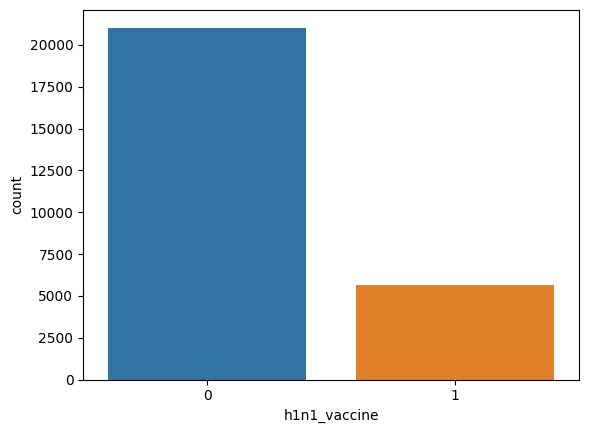

In [ ]:
h1n1_count = train.h1n1_vaccine.value_counts()
print('Class 0:', h1n1_count[0])
print('Class 1:', h1n1_count[1])
print('Proportion:', round(h1n1_count[0] / h1n1_count[1], 2), ': 1')
print('')
sns.countplot(data=train, x='h1n1_vaccine')

> It can be observed that the data is imbalanced with a ratio of 3.71:1. Therefore, it needs to be addressed.

Class 0: 14272
Class 1: 12435
Proportion: 1.15 : 1



<Axes: xlabel='seasonal_vaccine', ylabel='count'>

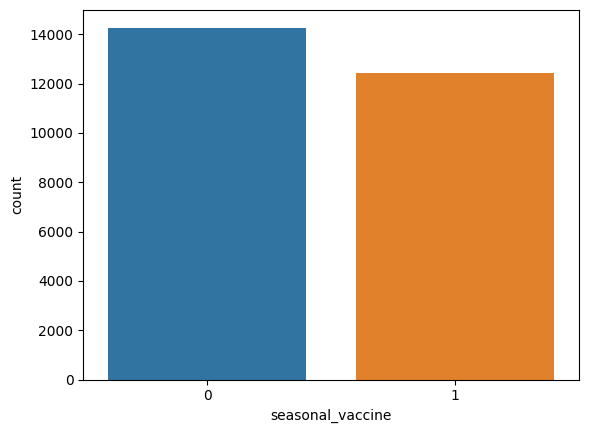

In [ ]:
seasonal_count = train.seasonal_vaccine.value_counts()
print('Class 0:', seasonal_count[0])
print('Class 1:', seasonal_count[1])
print('Proportion:', round(seasonal_count[0] / seasonal_count[1], 2), ': 1')
print('')
sns.countplot(data=train, x='seasonal_vaccine')

> It can be noted that the data is slightly imbalanced with a ratio of 1.15:1. Therefore, it would be beneficial to handle it.

> Based on the two visualizations above, it can also be observed that there are more respondents who have received the seasonal vaccine compared to the H1N1 vaccine.

## Demographical

In [ ]:
demographical_vars = [
    'age_group', 'education', 'race', 'sex',
    'income_poverty', 'marital_status', 'rent_or_own',
    'employment_status', 'employment_industry', 'employment_occupation',
    'hhs_geo_region', 'census_msa'
]

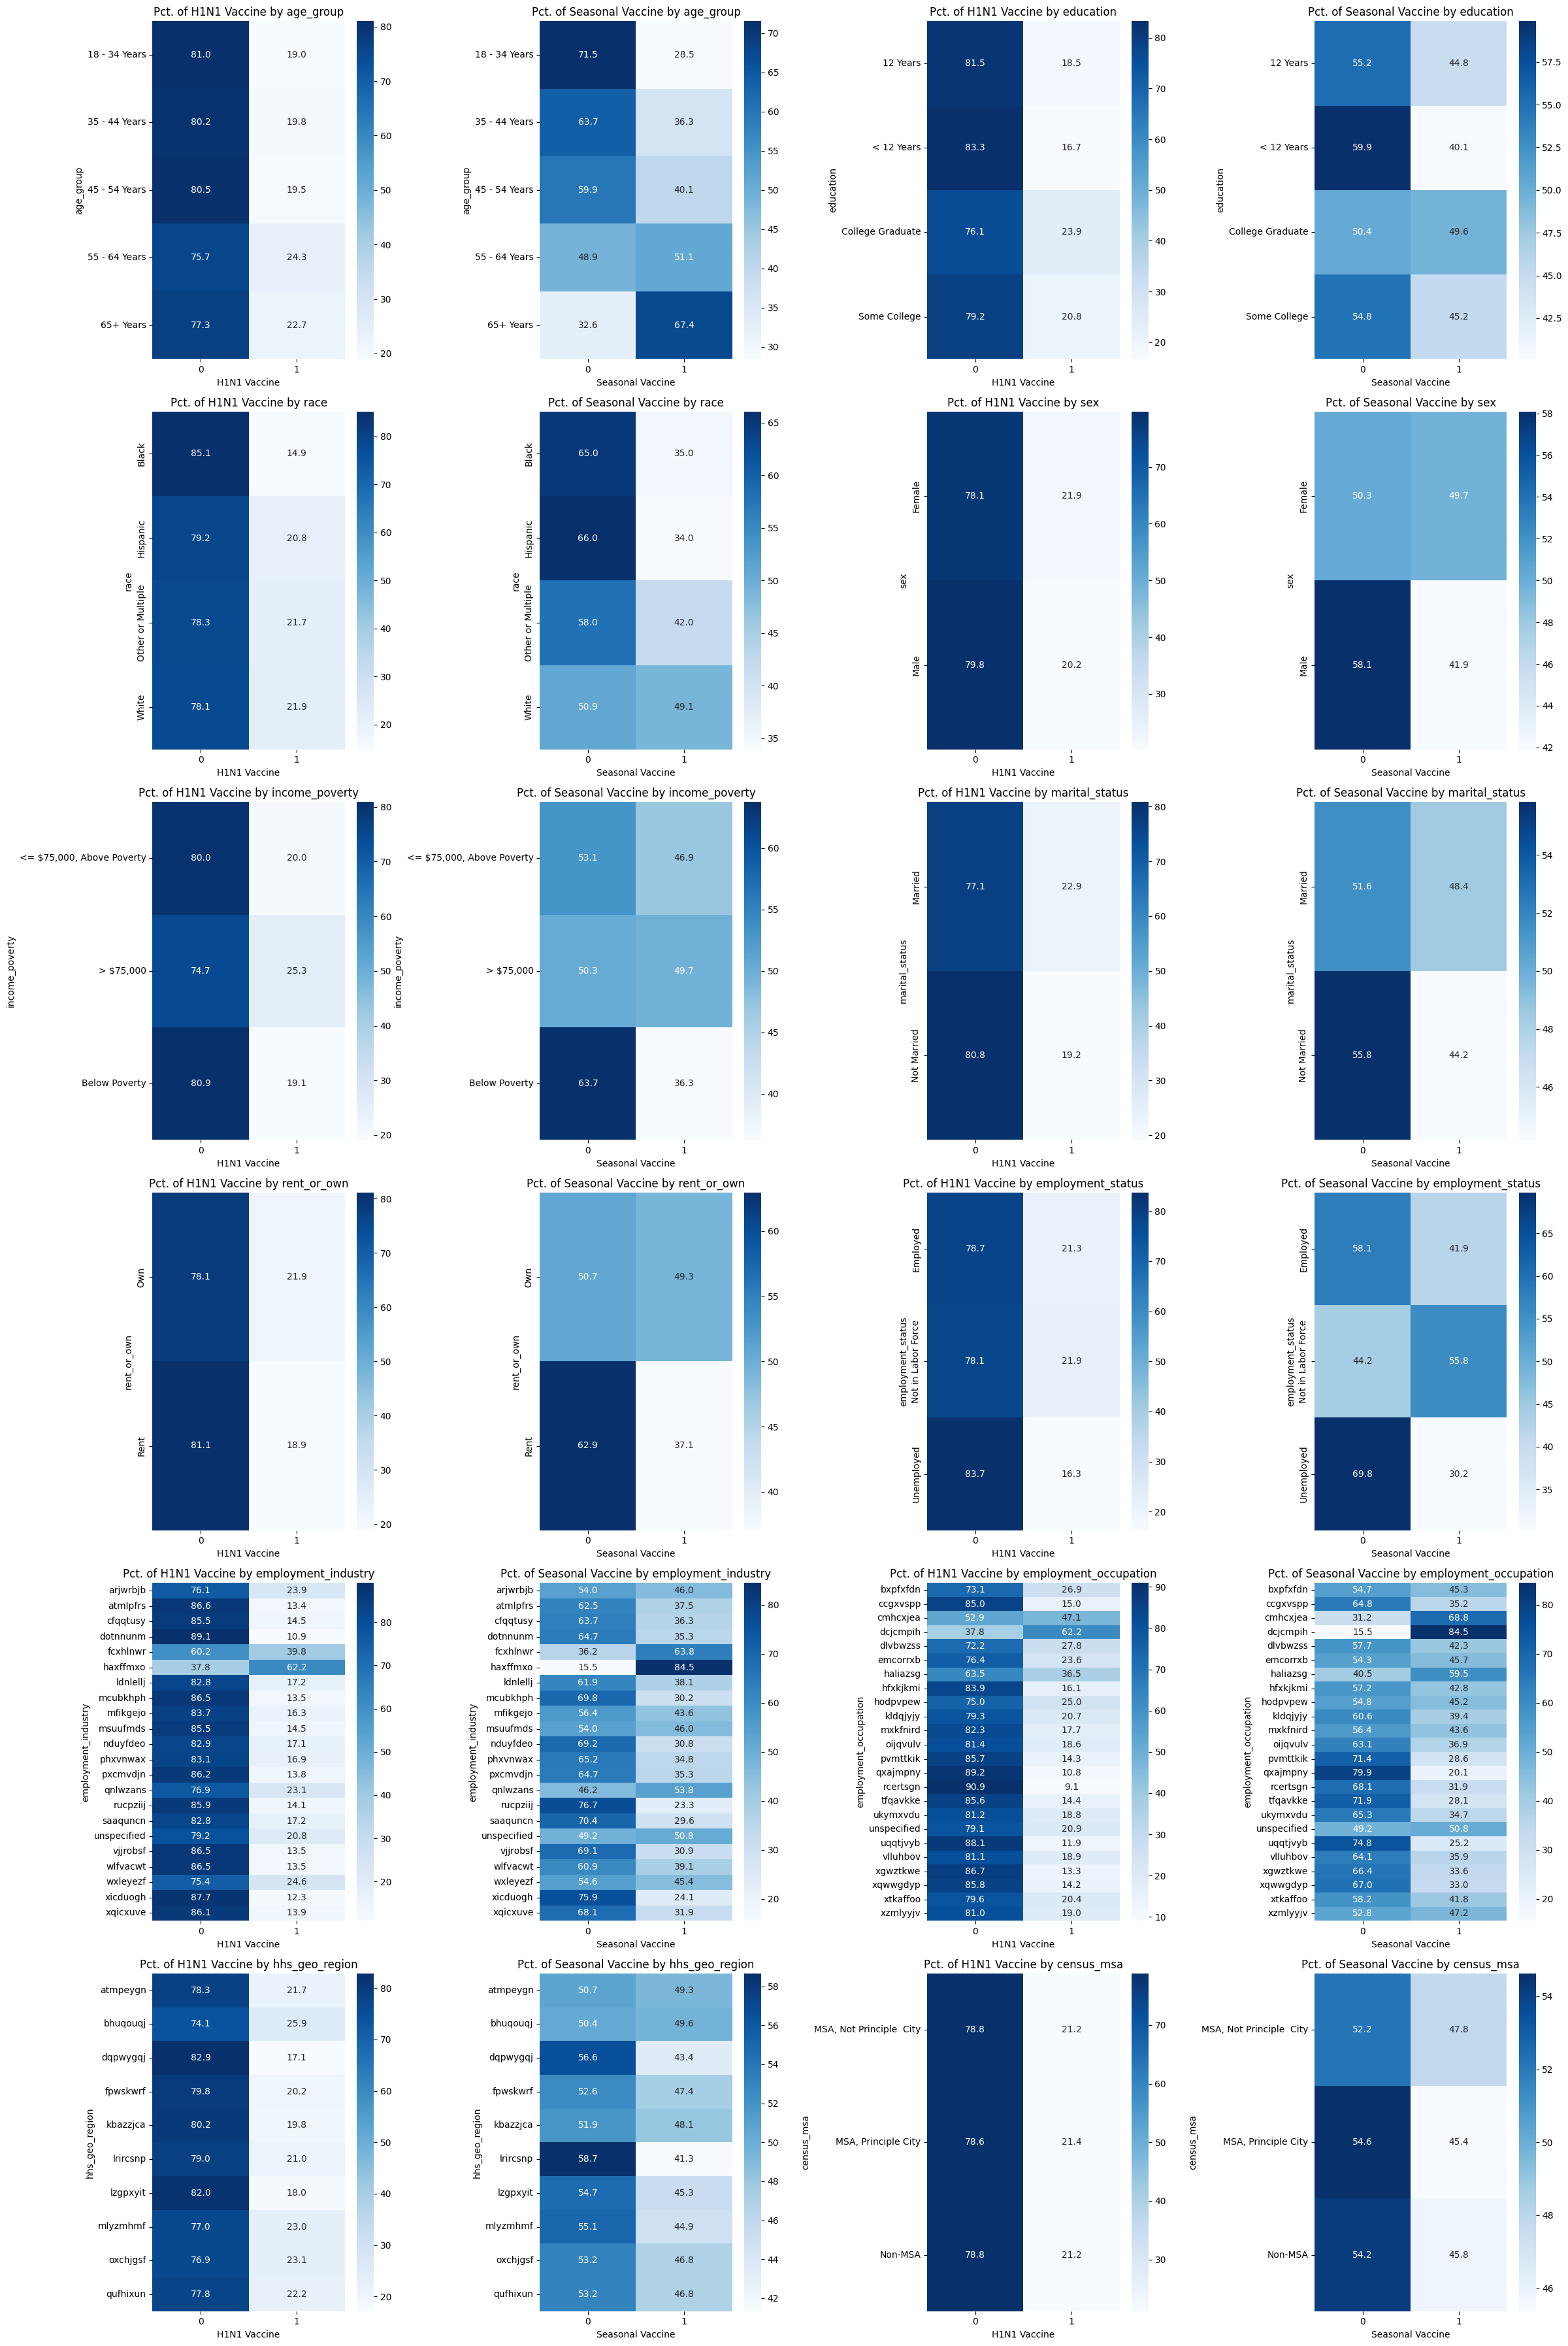

In [ ]:
heat_map(demographical_vars)

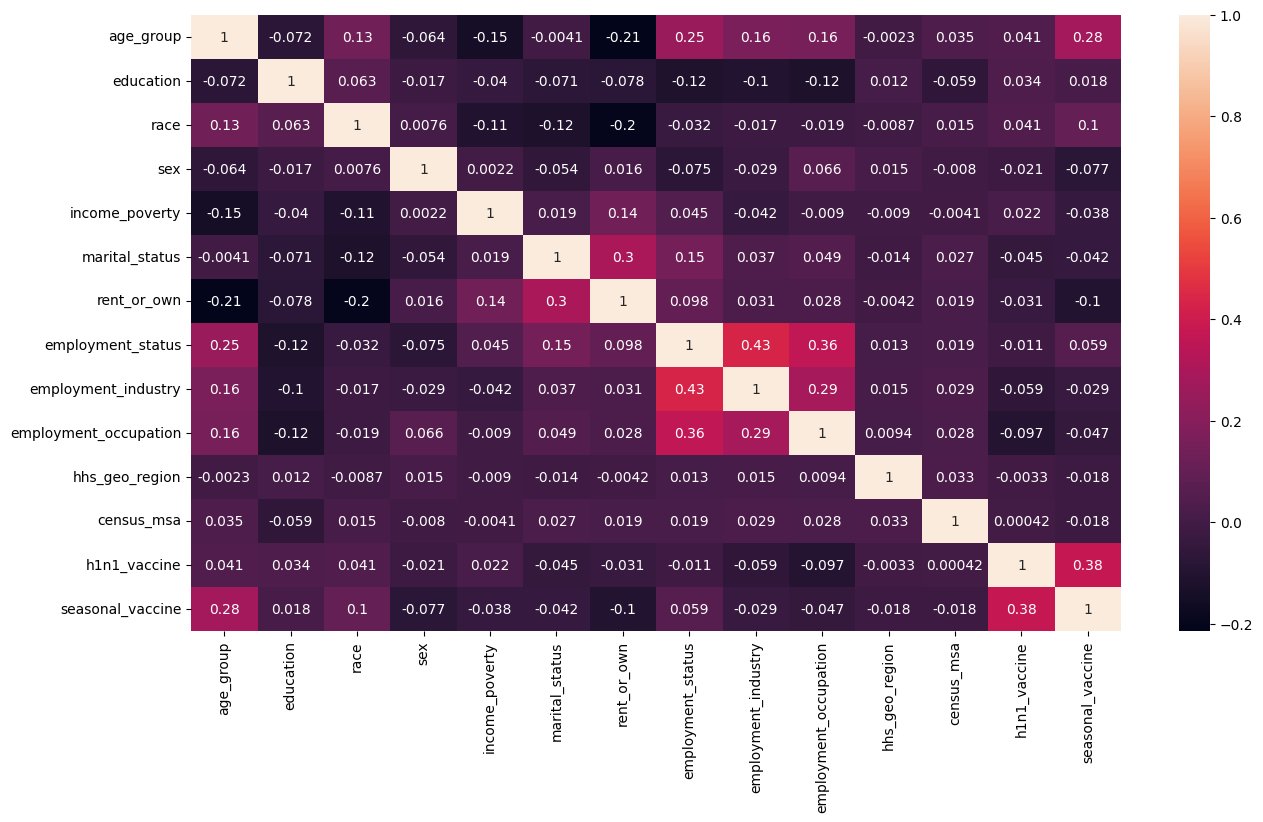

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(train[demographical_vars + ['h1n1_vaccine', 'seasonal_vaccine']].corr(), ax=ax, annot=True)
plt.show()

> It can be observed that the demographic data of individuals who have received the seasonal vaccine is more diverse compared to those who have received the H1N1 vaccine. This could be due to a larger number of respondents who have received the seasonal vaccine.

> Individuals who have received both the H1N1 and seasonal vaccines are slightly dominated by the following characteristics: they are college graduates, white, female, have an income_poverty above $75,000, are married, have their own place of residence, are not in the labor force, work in the employment industry "haxffmxo," work as "dcjcmpih," and live in "bhuqouqj."

## Behavioral


In [ ]:
behavioral_vars = [
    'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
    'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
    'behavioral_touch_face'
]

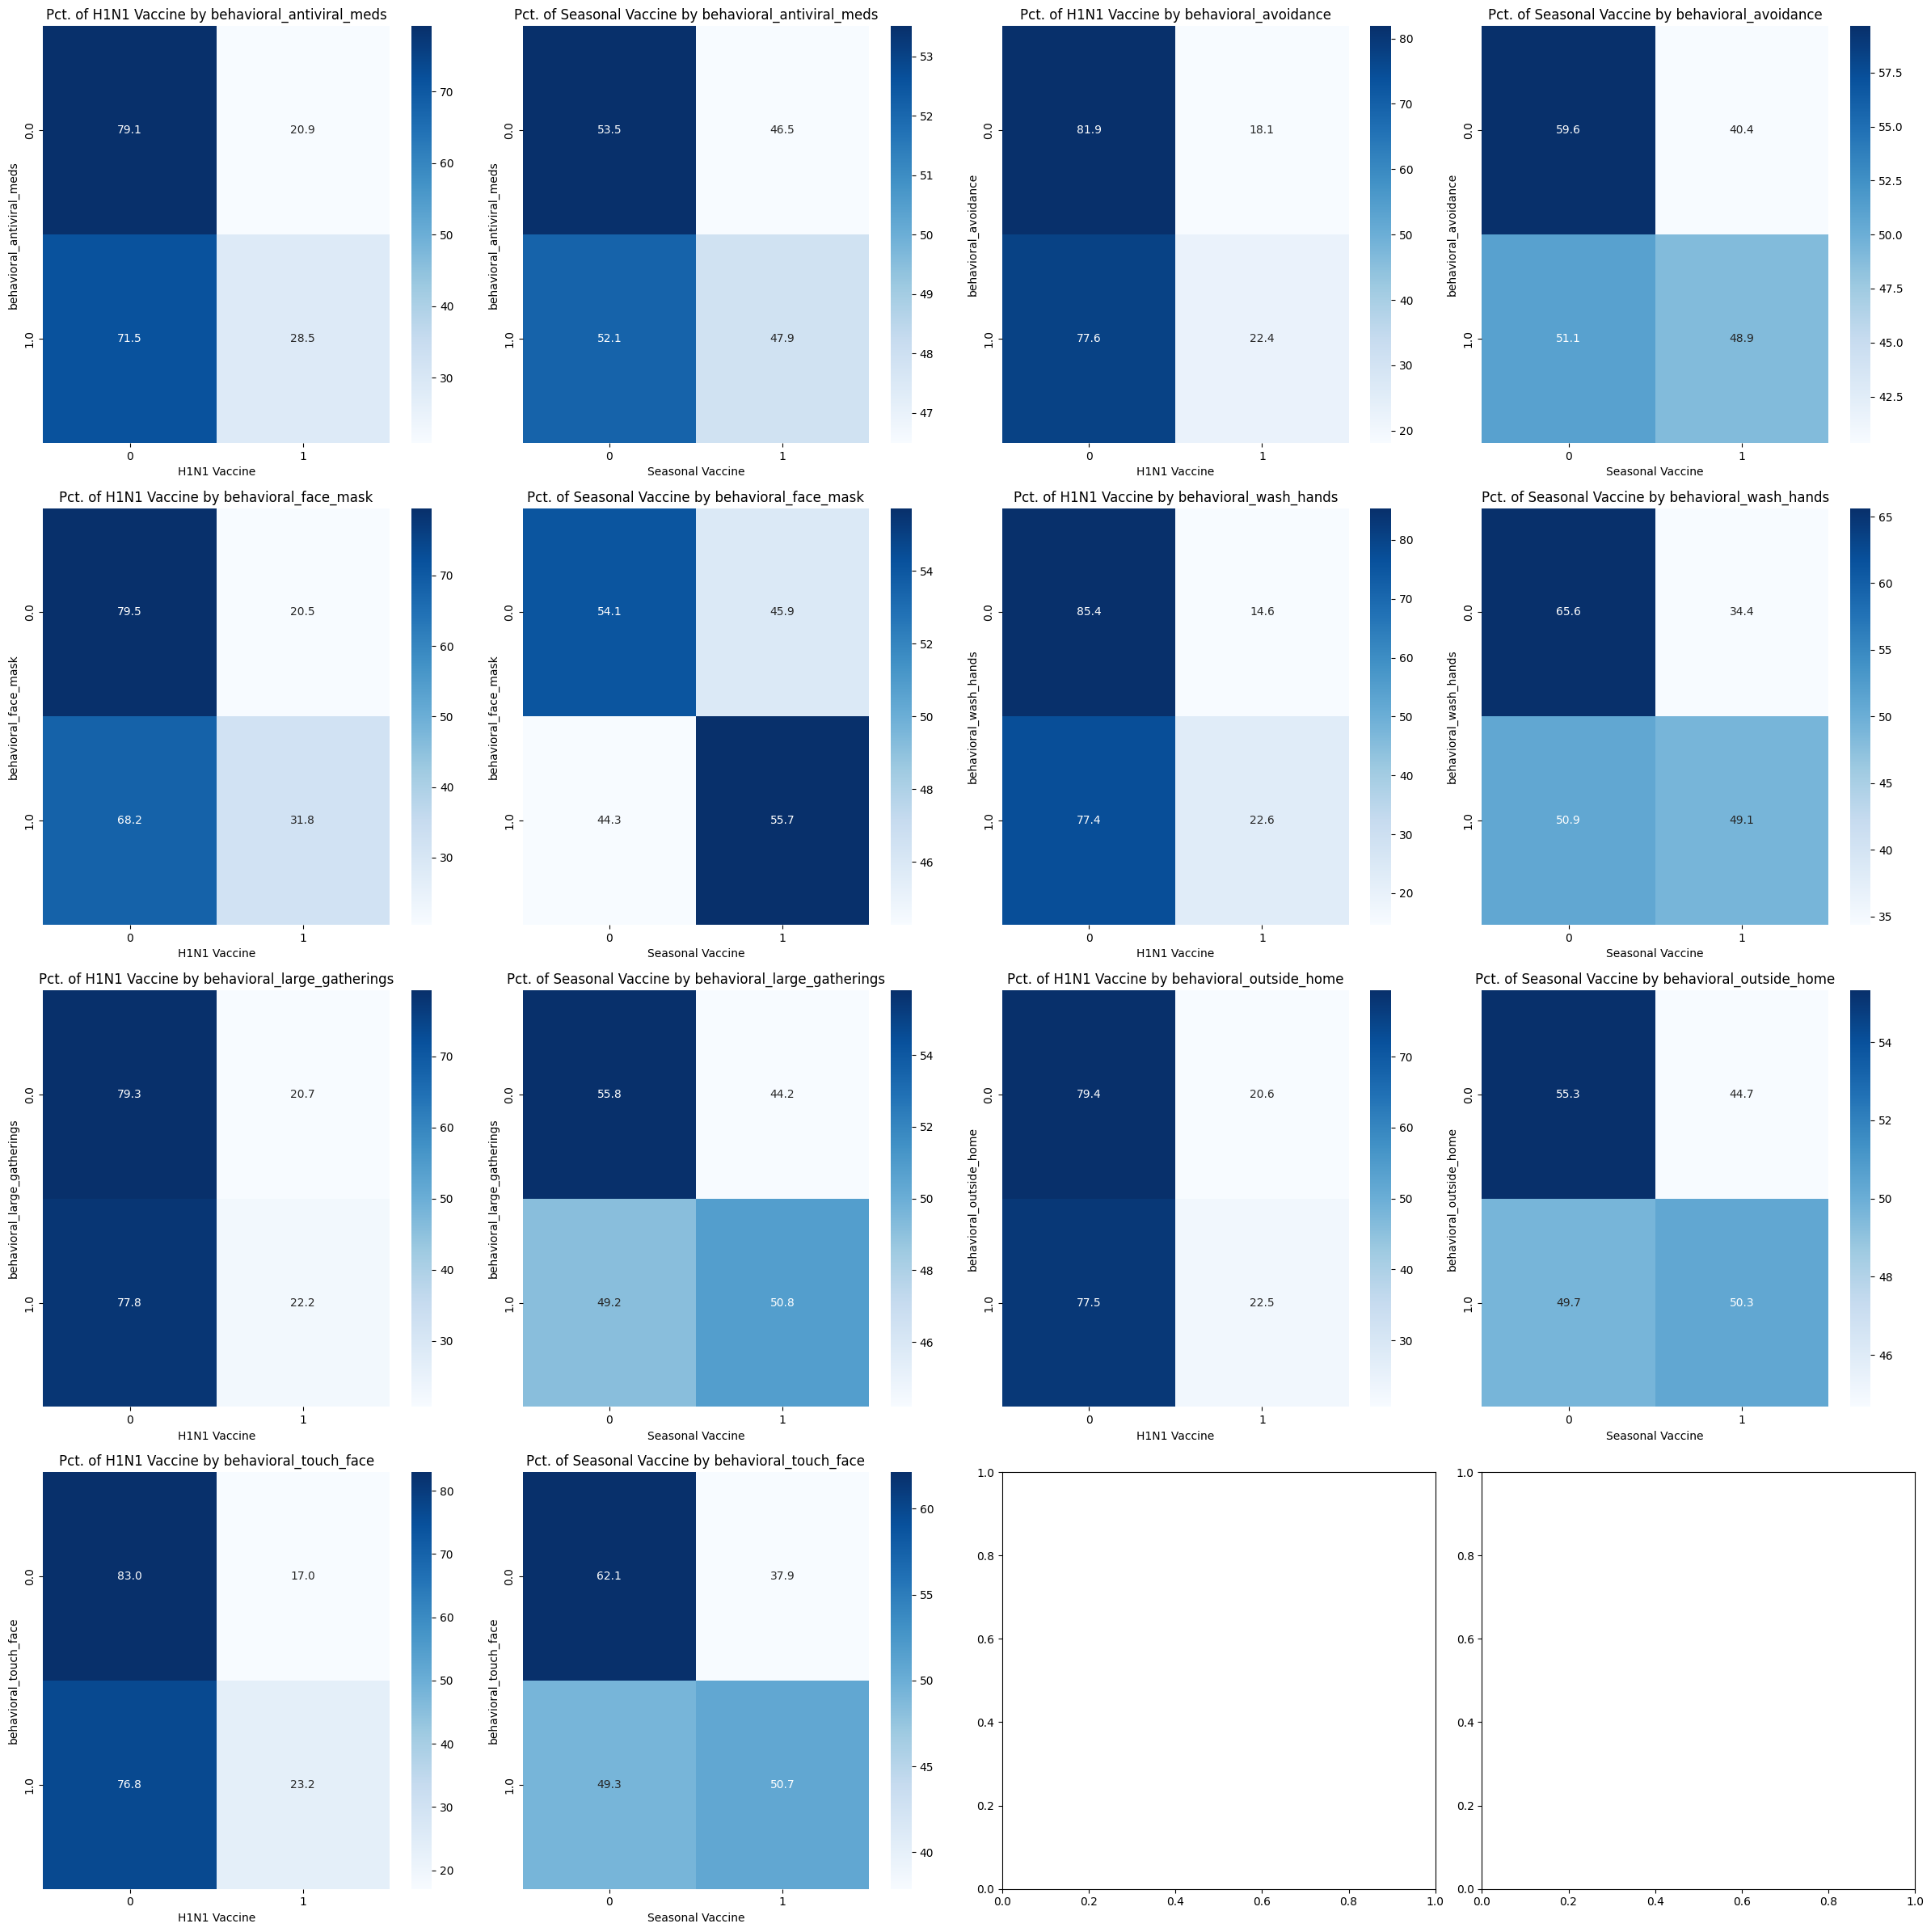

In [ ]:
heat_map(behavioral_vars)

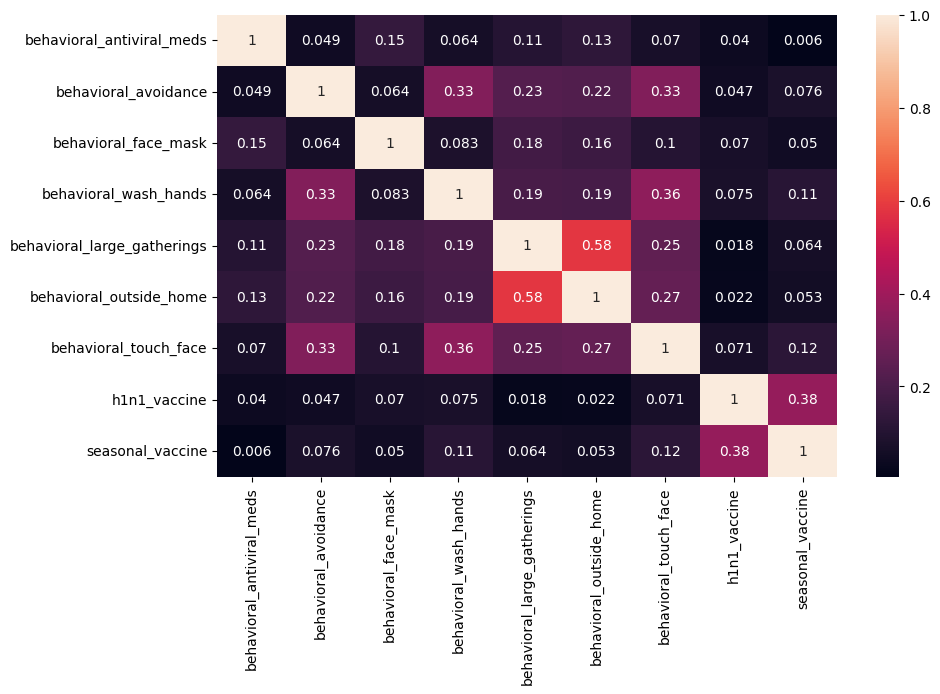

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(train[behavioral_vars + ['h1n1_vaccine', 'seasonal_vaccine']].corr(), ax=ax, annot=True)
plt.show()

> The behavioral traits related to flu prevention can influence individuals' decisions to receive the seasonal vaccine more than h1n1 vaccine. 

> Respondents who have reduced contact with people outside of their own household (behavioral_outside_home), reduced time at large gatherings (behavioral_large_gatherings), and have bought a face mask (behavioral_face_mask) are more likely to consider getting the vaccine.




## Opinion

In [ ]:
opinion_vars = [
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'
]

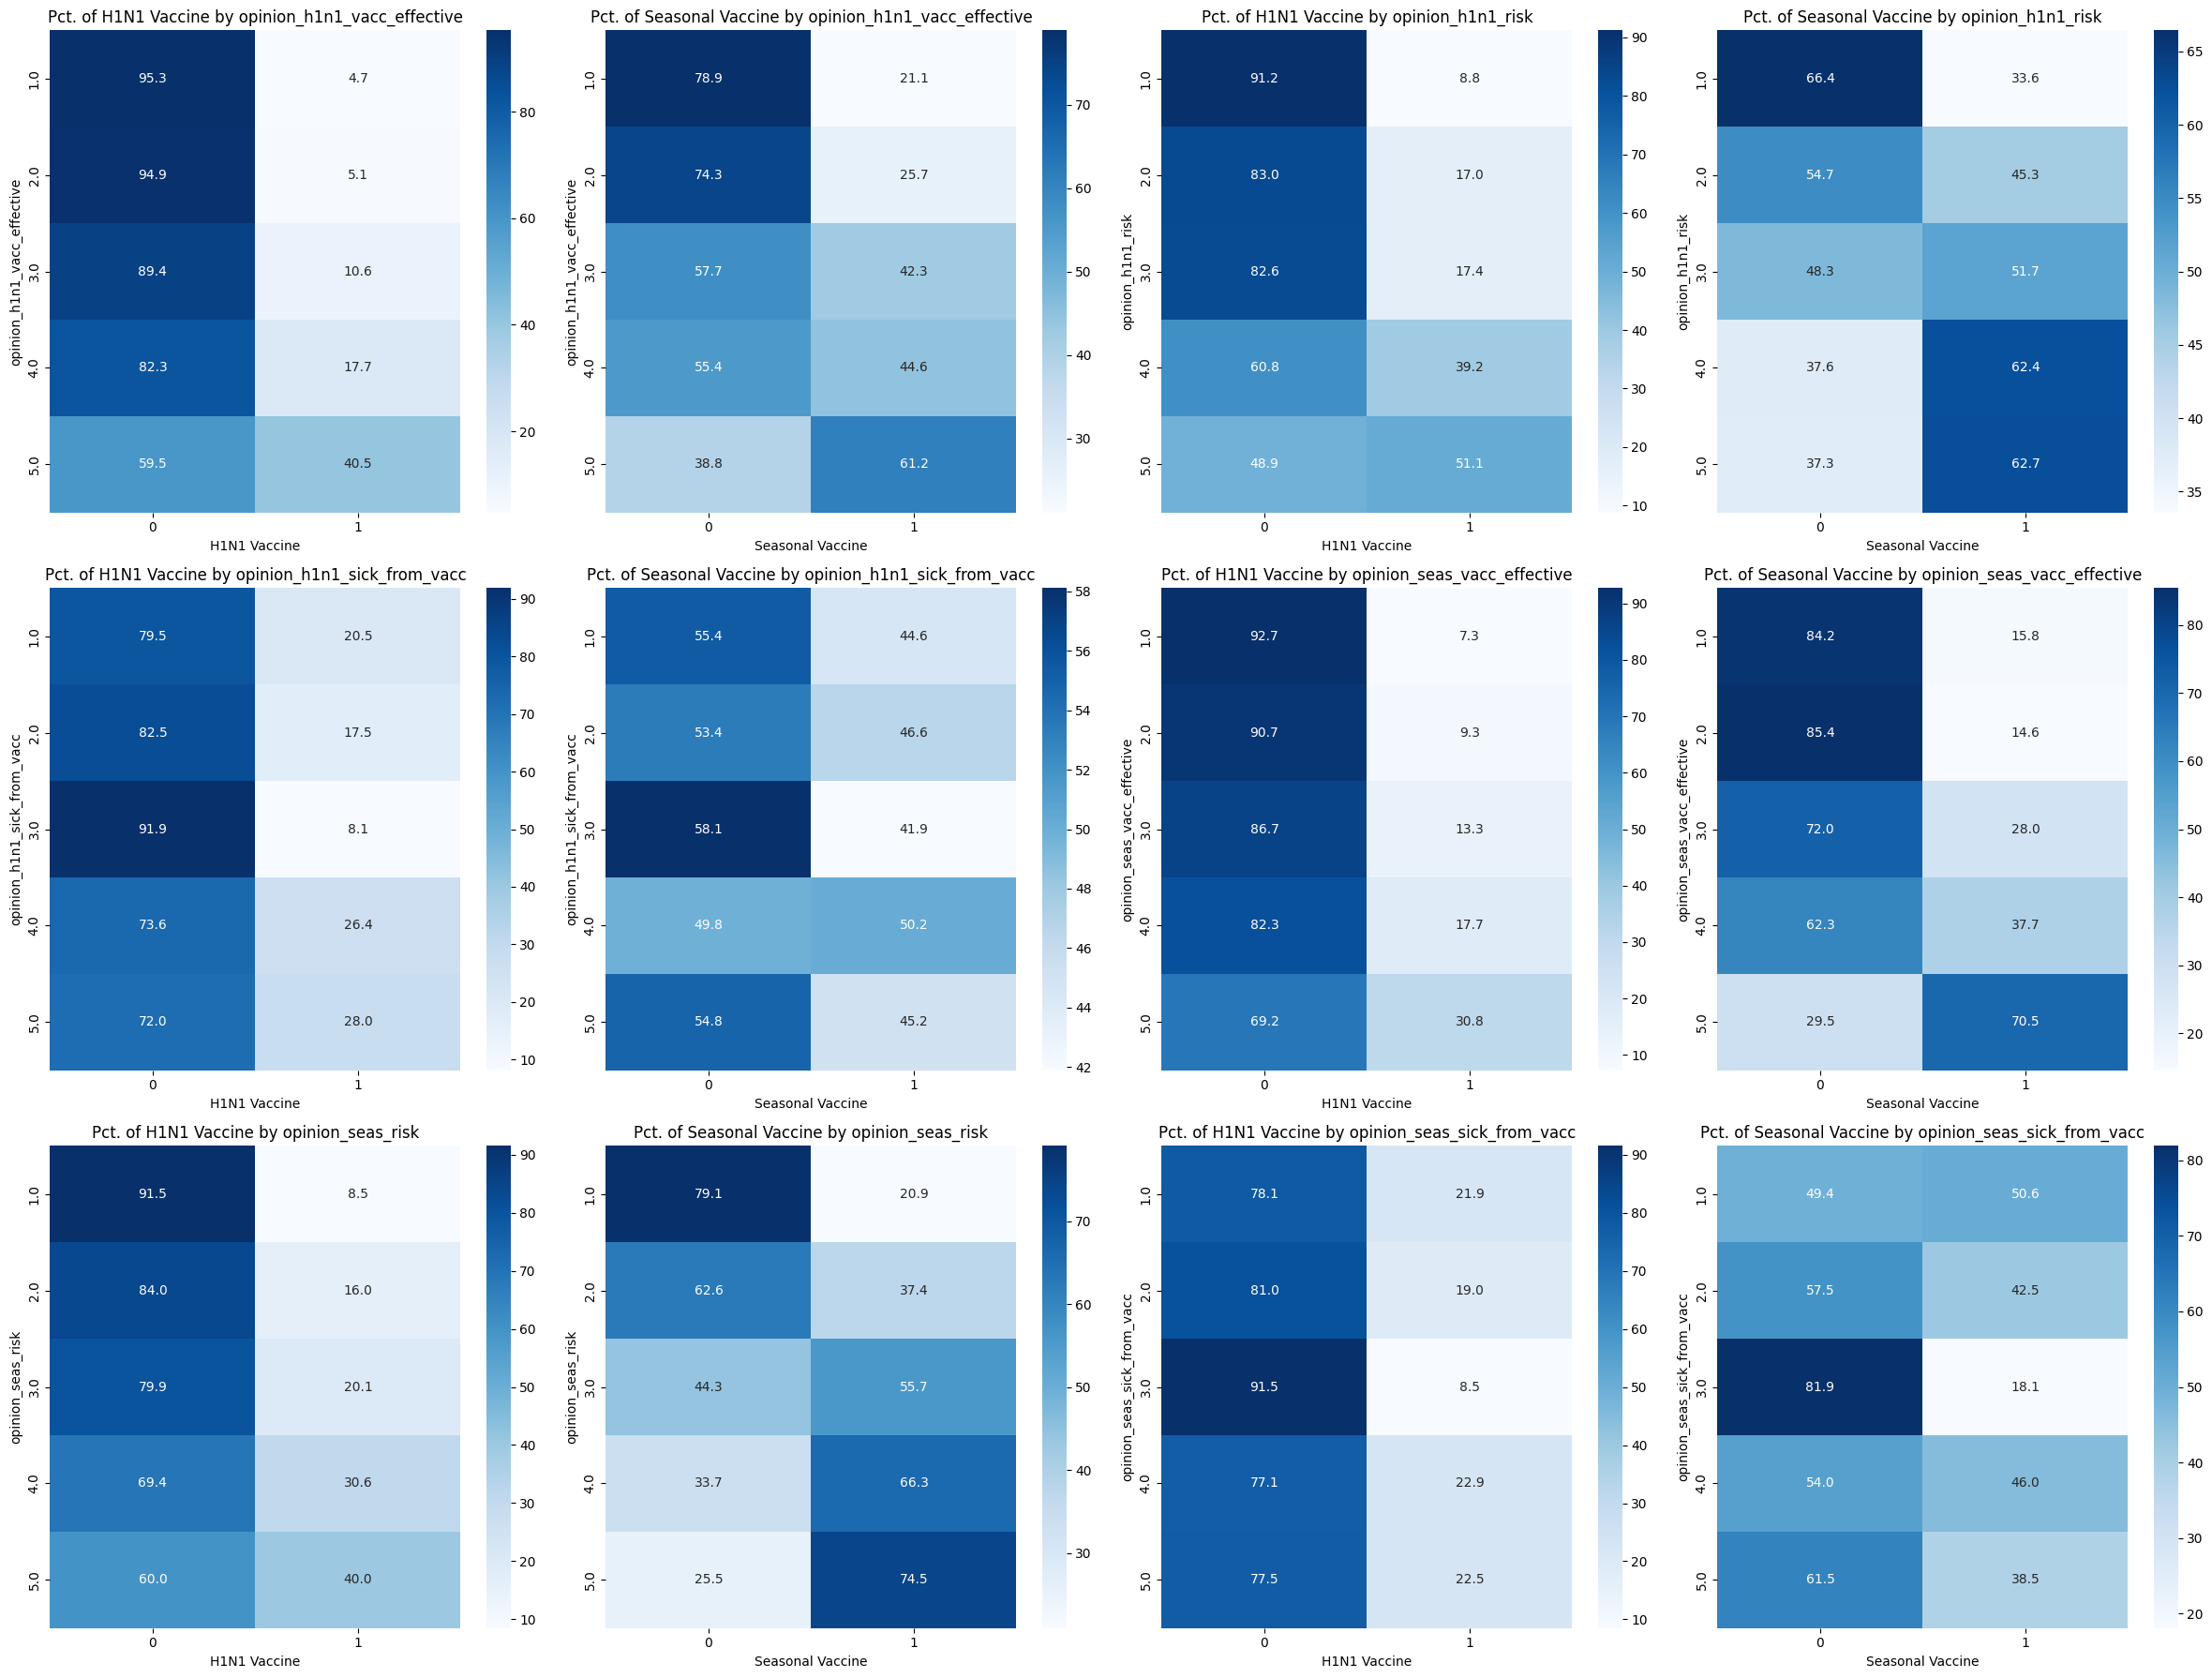

In [ ]:
heat_map(opinion_vars)

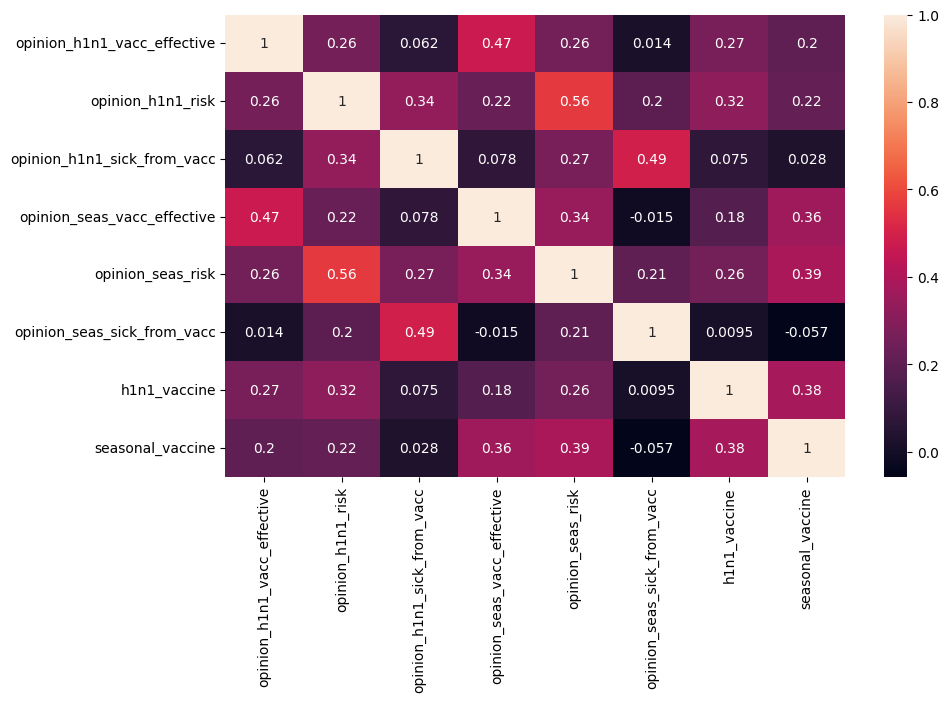

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(train[opinion_vars  + ['h1n1_vaccine', 'seasonal_vaccine']].corr(), ax=ax, annot=True)
plt.show()

> Opinions of respondents towards the H1N1 vaccine and seasonal vaccine can influence their decision to get vaccinated. If someone has a positive opinion towards vaccination, they are more likely to choose to get vaccinated. On the other hand, if individuals have a negative opinion towards vaccination, they may be hesitant to receive the vaccine.

## Health-Related

In [ ]:
health_vars = [
    'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
    'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months',
    'health_worker'
]

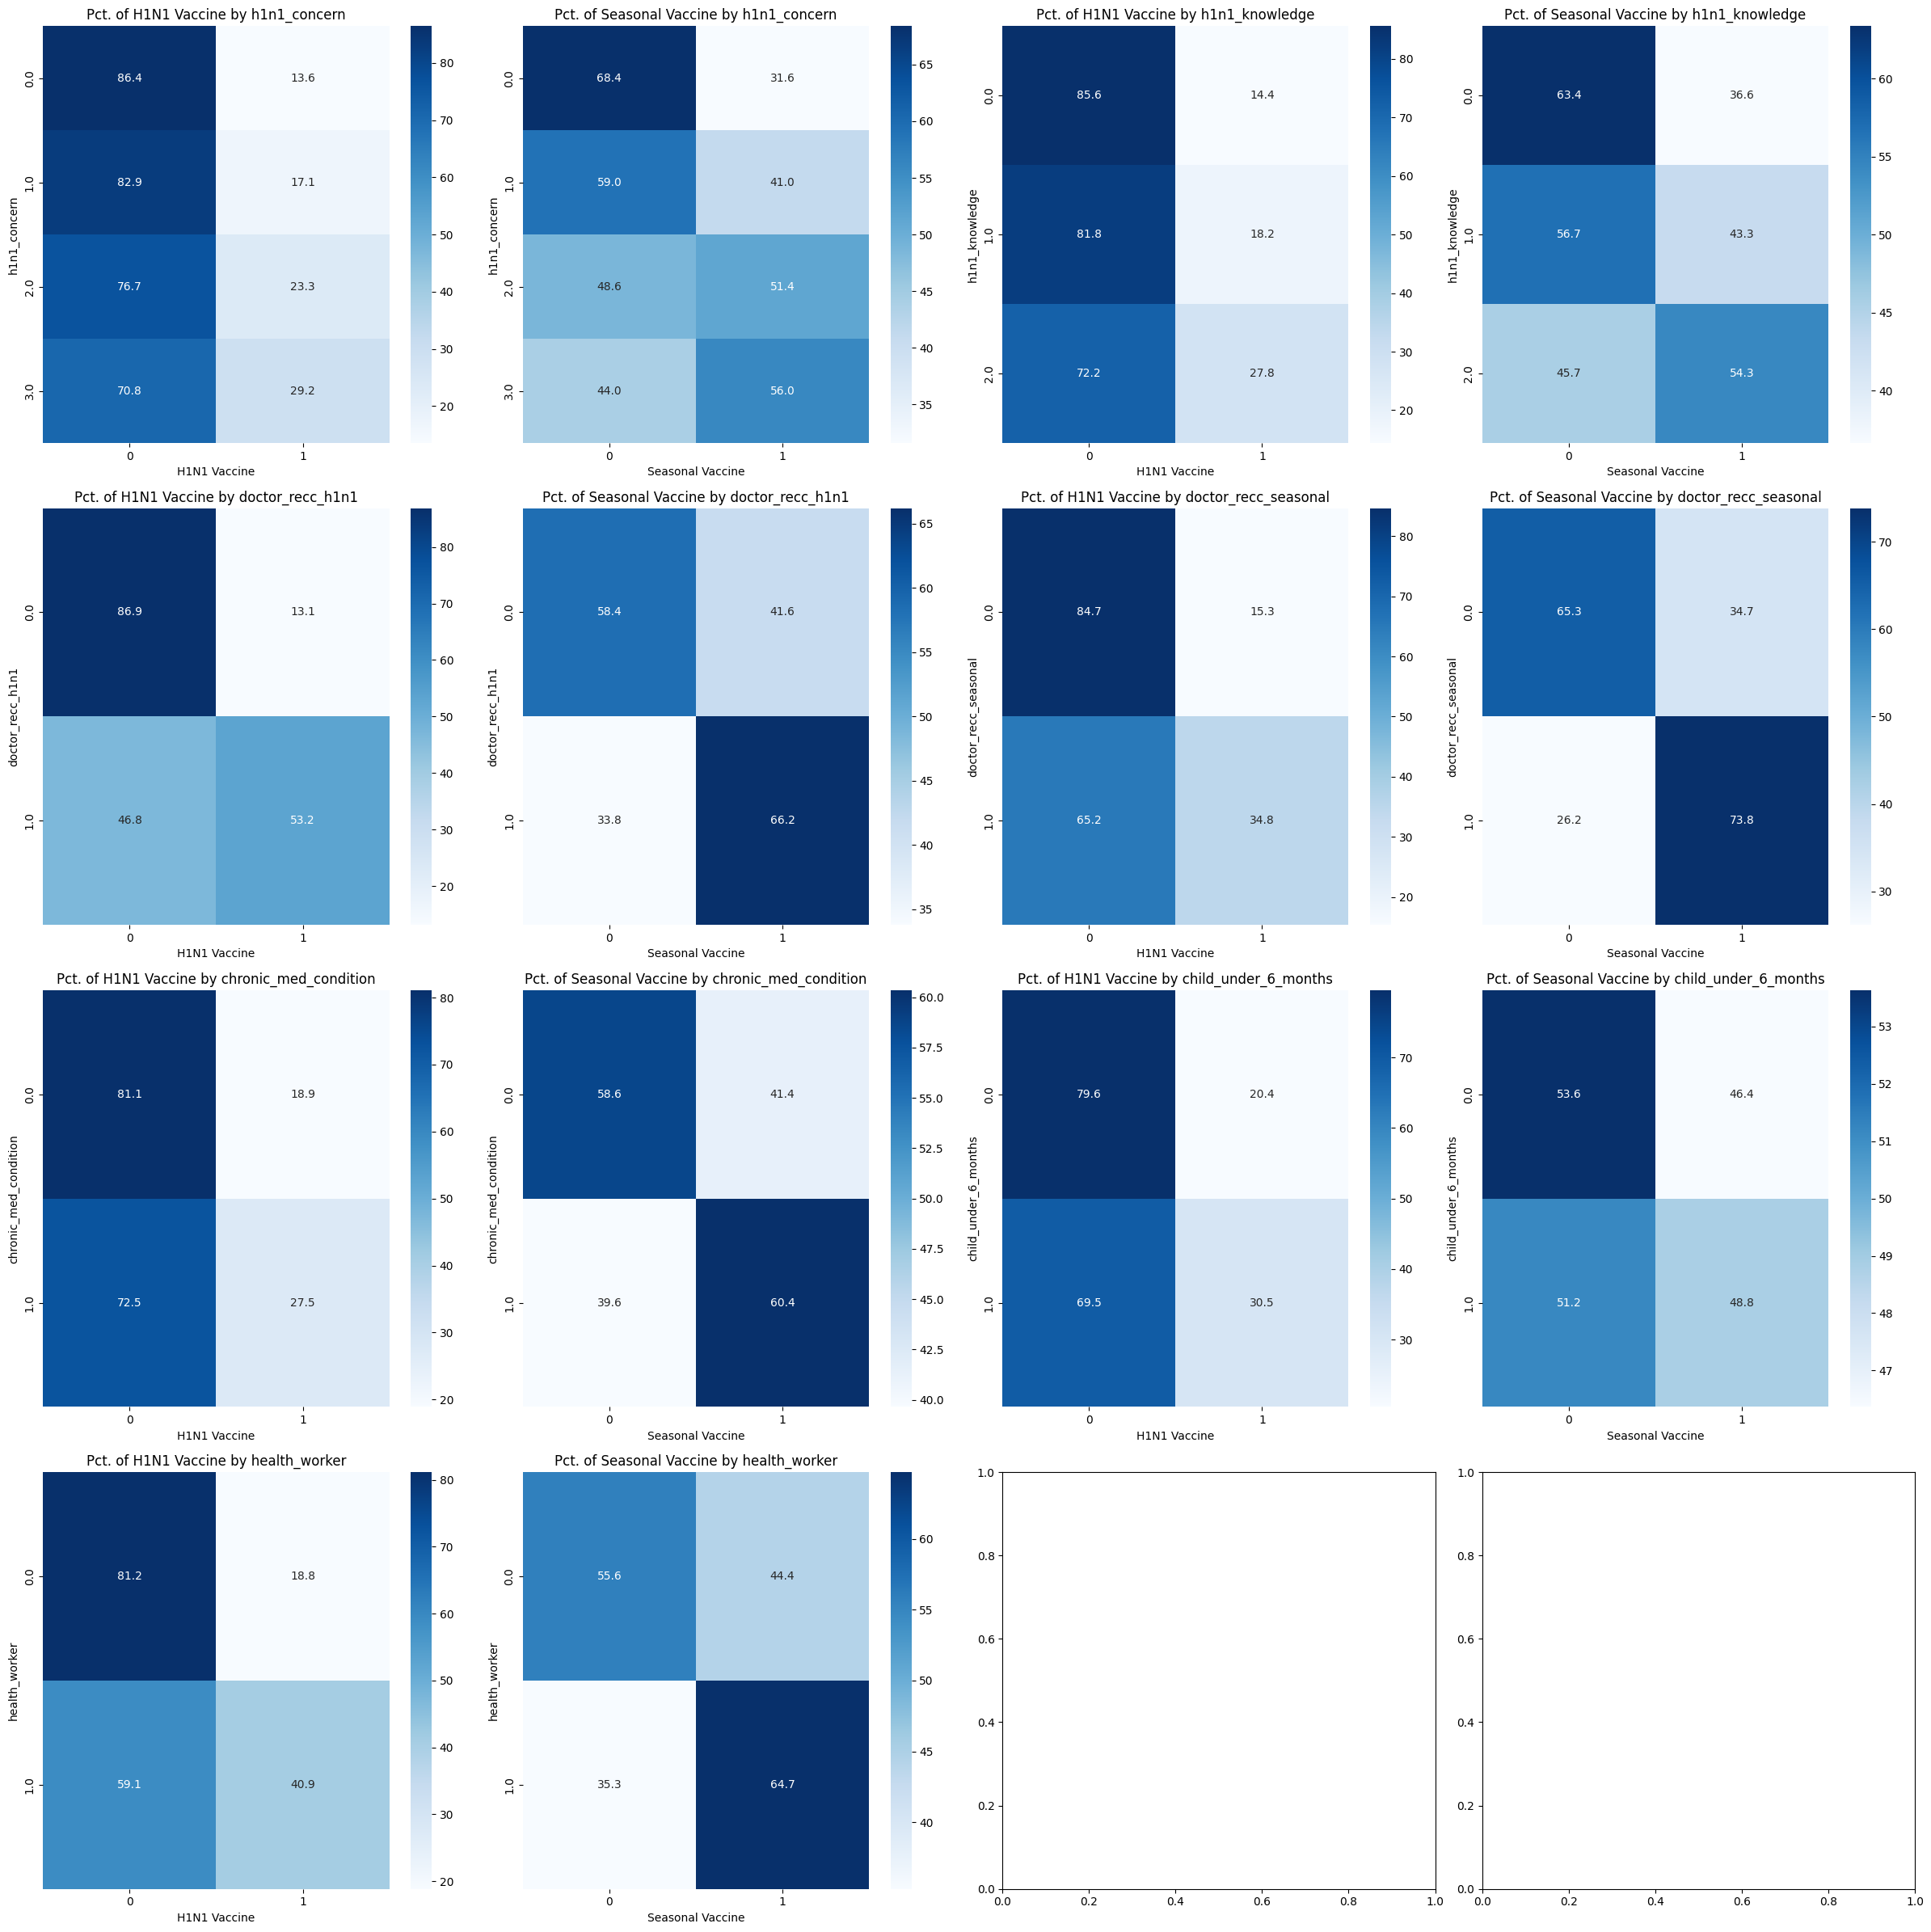

In [ ]:
heat_map(health_vars)

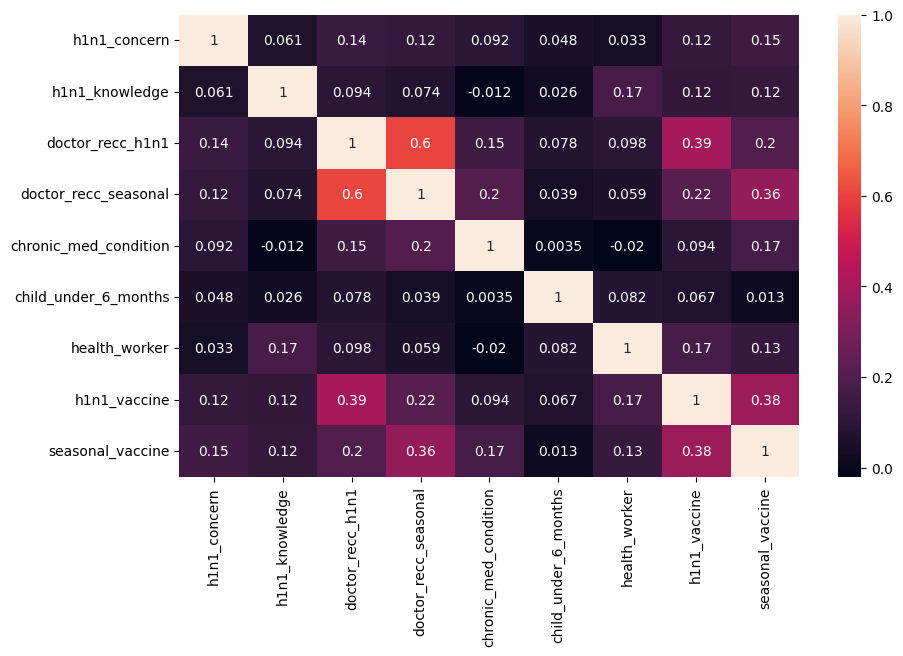

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(train[health_vars + ['h1n1_vaccine', 'seasonal_vaccine']].corr(), ax=ax, annot=True)
plt.show()

> Respondents who have concerns and knowledge about vaccines are more likely to get vaccinated. Additionally, recommendations from doctors have a significant influence on respondents' decisions to receive the vaccine. The medical history of the respondents and is a health worker has a minor impact, but it does not apply to respondents who are in close contact with a child under the age of six months.

# Modelling


In [ ]:
X = train.drop(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis = 1)
y1 = train['h1n1_vaccine']
y2 = train['seasonal_vaccine']

## Scale The Train and Test Data

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
test_id = test['respondent_id']
test_features = test.drop(['respondent_id'], axis=1)
test_scaled = scaler.transform(test_features)

## Split The Train Data

In [ ]:
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X_scaled, y1, y2, test_size=0.2)

## Assess The Best Model to Train

In [ ]:
classifiers = [
    ('RF', RandomForestClassifier()),
    ('GBM', GradientBoostingClassifier()),
    ('LR', LogisticRegression()),
    ('SGD', SGDClassifier()),
    ('KNN', KNeighborsClassifier(5)),
    ('SVC', SVC()),
    ('LiSVC', LinearSVC()),
    ('DT', DecisionTreeClassifier()),
    ('ET', ExtraTreeClassifier()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('XGB', XGBClassifier()),
    ('GNB', GaussianNB()),
    ]

result = pd.DataFrame(columns=['Classifier', 'ROC AUC y1', 'ROC AUC y2'])

for name, model in classifiers:
    cv_scores_1 = cross_val_score(model, X_train, y1_train, cv=5, scoring='roc_auc')
    mean_roc_auc_1 = cv_scores_1.mean()

    cv_scores_2 = cross_val_score(model, X_train, y2_train, cv=5, scoring='roc_auc')
    mean_roc_auc_2 = cv_scores_2.mean()

    result.loc[len(result)] = [name, mean_roc_auc_1, mean_roc_auc_2]

In [ ]:
result.sort_values('ROC AUC y1', ascending=False).reset_index(drop=True)

,Classifier,ROC AUC y1,ROC AUC y2
0,GBM,0.864915,0.861257
1,RF,0.855532,0.853137
2,XGB,0.850832,0.847240
3,LR,0.845590,0.846507
4,LiSVC,0.845513,0.846398
5,LDA,0.843194,0.846064
6,SGD,0.842515,0.844723
7,SVC,0.840466,0.851224
8,QDA,0.820718,0.818263
9,GNB,0.802141,0.801616


In [ ]:
result.sort_values('ROC AUC y2', ascending=False).reset_index(drop=True)

,Classifier,ROC AUC y1,ROC AUC y2
0,GBM,0.864915,0.861257
1,RF,0.855532,0.853137
2,SVC,0.840466,0.851224
3,XGB,0.850832,0.847240
4,LR,0.845590,0.846507
5,LiSVC,0.845513,0.846398
6,LDA,0.843194,0.846064
7,SGD,0.842515,0.844723
8,QDA,0.820718,0.818263
9,GNB,0.802141,0.801616


> It can be observed that the best model used to predict y1 and y2 is the GradientBoostingClassifier.

## Features Reduction

In [ ]:
best_k = None
best_roc_auc_k = 0
for k in range(1, X.shape[1] + 1):
    selector = SelectKBest(score_func=f_classif, k=k)
    X1_train_selected = selector.fit_transform(X_train, y1_train)
    X1_test_selected = selector.transform(X_test)

    model = GradientBoostingClassifier()
    model_kbest = model.fit(X1_train_selected, y1_train)
    y1_pred_kbest = model_kbest.predict(X1_test_selected)
    roc_auc_kbest = roc_auc_score(y1_test, y1_pred_kbest)
    
    if roc_auc_kbest > best_roc_auc_k:
        best_roc_auc_k = roc_auc_kbest
        best_k = k
        
print("Best k value:", best_k)
print("Best roc_auc:", best_roc_auc_k)

Best k value: 32
Best roc_auc: 0.7262944537267445


In [ ]:
selector = SelectKBest(score_func=f_classif, k=best_k)
X1_train_selected = selector.fit_transform(X_train, y1_train)
X1_test_selected = selector.transform(X_test)
test_selected_1 = selector.transform(test_scaled)

In [ ]:
best_k = None
best_roc_auc_k = 0
for k in range(1, X.shape[1] + 1):
    selector = SelectKBest(score_func=f_classif, k=k)
    X2_train_selected = selector.fit_transform(X_train, y2_train)
    X2_test_selected = selector.transform(X_test)

    model = GradientBoostingClassifier()
    model_kbest = model.fit(X2_train_selected, y2_train)
    y2_pred_kbest = model_kbest.predict(X2_test_selected)
    roc_auc_kbest = roc_auc_score(y2_test, y2_pred_kbest)
    
    if roc_auc_kbest > best_roc_auc_k:
        best_roc_auc_k = roc_auc_kbest
        best_k = k
        
print("Best k value:", best_k)
print("Best roc_auc:", best_roc_auc_k)

Best k value: 30
Best roc_auc: 0.7855358135932474


In [ ]:
selector = SelectKBest(score_func=f_classif, k=best_k)
X2_train_selected = selector.fit_transform(X_train, y1_train)
X2_test_selected = selector.transform(X_test)
test_selected_ = selector.transform(test_scaled)

# Evaluate Model

In [ ]:
classifiers = [
    ('GBM', GradientBoostingClassifier()),
    ]

result_y1 = pd.DataFrame(columns=['Classifier', 'ROC AUC normal', 'ROC AUC k-best'])

for name, model in classifiers:
    cv_scores_1 = cross_val_score(model, X_train, y1_train, cv=5, scoring='roc_auc')
    mean_roc_auc_1 = cv_scores_1.mean()
    
    cv_scores_2 = cross_val_score(model, X1_train_selected, y1_train, cv=5, scoring='roc_auc')
    mean_roc_auc_2 = cv_scores_2.mean()

    result_y1.loc[len(result_y1)] = [name, mean_roc_auc_1, mean_roc_auc_2]

In [ ]:
result_y1.sort_values('ROC AUC k-best', ascending=False).reset_index(drop=True)

,Classifier,ROC AUC normal,ROC AUC k-best
0,GBM,0.864915,0.864972


In [ ]:
classifiers = [
    ('GBM', GradientBoostingClassifier()),
    ]

result_y2 = pd.DataFrame(columns=['Classifier', 'ROC AUC normal', 'ROC AUC k-best'])

for name, model in classifiers:
    cv_scores_1 = cross_val_score(model, X_train, y2_train, cv=5, scoring='roc_auc')
    mean_roc_auc_1 = cv_scores_1.mean()
    
    cv_scores_2 = cross_val_score(model, X2_train_selected, y2_train, cv=5, scoring='roc_auc')
    mean_roc_auc_2 = cv_scores_2.mean()

    result_y2.loc[len(result_y1)] = [name, mean_roc_auc_1, mean_roc_auc_2]

In [ ]:
result_y2.sort_values('ROC AUC k-best', ascending=False).reset_index(drop=True)

,Classifier,ROC AUC normal,ROC AUC k-best
0,GBM,0.861257,0.857857


> It can be observed that the model for predicting y1 performs better when using features that have been selected using SelectKBest. On the other hand, for predicting y2, the model performs well without feature selection.

## Search The Best Parameters

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

model_1 = GradientBoostingClassifier()
grid_search_1 = GridSearchCV(model_1, param_grid, cv=5)
grid_search_1.fit(X1_train_selected, y1_train)
best_params_1 = grid_search_1.best_params_
best_score_1 = grid_search_1.best_score_

print("Best parameters:", best_params_1)
print("Best score:", best_score_1)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best score: 0.8581792651532879


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

model_2 = GradientBoostingClassifier()
grid_search_2 = GridSearchCV(model_2, param_grid, cv=5)
grid_search_2.fit(X_train, y2_train)
best_params_2 = grid_search_2.best_params_
best_score_2 = grid_search_2.best_score_

print("Best parameters:", best_params_2)
print("Best score:", best_score_2)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.7860051486075357


## Handle Imbalanced

In [ ]:
best_model_1 = GradientBoostingClassifier(**best_params_1)
best_model_2 = GradientBoostingClassifier(**best_params_2)

In [ ]:
result_y1 = pd.DataFrame(columns=['sampler', 'roc_auc_score'])

In [ ]:
oversamplers = [
    ('RandomOverSampler', RandomOverSampler(sampling_strategy='minority')),
    ('SMOTE', SMOTE()),
    ('BorderlineSMOTE', BorderlineSMOTE()),
    ('SVMSMOTE', SVMSMOTE()),
    ('ADASYN', ADASYN())
    ]

for name, oversampler in oversamplers:
  X1_train_over, y1_train_over = oversampler.fit_resample(X1_train_selected, y1_train)
  best_model_1 = best_model_1.fit(X1_train_over, y1_train_over)
  y1_pred = best_model_1.predict(X1_test_selected)
  roc_auc = roc_auc_score(y1_test, y1_pred)
  
  result_y1.loc[len(result_y1)] = [name, roc_auc]

In [ ]:
undersamplers = [
    ('RandomUnderSampler', RandomUnderSampler(sampling_strategy='majority')),
    ('NearMiss1', NearMiss()),
    ('NearMiss2', NearMiss(version=2)),
    ('NearMiss3', NearMiss(version=3)),
    ('TomekLinks', TomekLinks()),
    ]

for name, undersampler in undersamplers:
  X1_train_under, y1_train_under = undersampler.fit_resample(X1_train_selected, y1_train)
  best_model_1 = best_model_1.fit(X1_train_under, y1_train_under)
  y1_pred = best_model_1.predict(X1_test_selected)
  roc_auc = roc_auc_score(y1_test, y1_pred)

  result_y1.loc[len(result_y1)] = [name, roc_auc]

In [ ]:
result_y1.sort_values('roc_auc_score', ascending=False).reset_index(drop=True)

,sampler,roc_auc_score
0,RandomOverSampler,0.780673
1,RandomUnderSampler,0.779448
2,NearMiss3,0.767897
3,SVMSMOTE,0.740624
4,BorderlineSMOTE,0.736959
5,SMOTE,0.736878
6,TomekLinks,0.735936
7,ADASYN,0.733459
8,NearMiss1,0.657090
9,NearMiss2,0.648377


In [ ]:
result_y2 = pd.DataFrame(columns=['sampler', 'roc_auc_score'])

In [ ]:
oversamplers = [
    ('RandomOverSampler', RandomOverSampler(sampling_strategy='minority')),
    ('SMOTE', SMOTE()),
    ('BorderlineSMOTE', BorderlineSMOTE()),
    ('SVMSMOTE', SVMSMOTE()),
    ]

for name, oversampler in oversamplers:
  X2_train_over, y2_train_over = oversampler.fit_resample(X_train, y2_train)
  best_model_2 = best_model_2.fit(X2_train_over, y2_train_over)
  y2_pred = best_model_2.predict(X_test)
  roc_auc = roc_auc_score(y2_test, y2_pred)
  
  result_y2.loc[len(result_y2)] = [name, roc_auc]

In [ ]:
undersamplers = [
    ('RandomUnderSampler', RandomUnderSampler(sampling_strategy='majority')),
    ('NearMiss1', NearMiss()),
    ('NearMiss2', NearMiss(version=2)),
    ('NearMiss3', NearMiss(version=3)),
    ('TomekLinks', TomekLinks()),
    ]

for name, undersampler in undersamplers:
  X2_train_under, y2_train_under = undersampler.fit_resample(X_train, y2_train)
  best_model_2 = best_model_2.fit(X2_train_under, y2_train_under)
  y2_pred = best_model_2.predict(X_test)
  roc_auc = roc_auc_score(y2_test, y2_pred)
  
  result_y2.loc[len(result_y2)] = [name, roc_auc]

/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [ ]:
result_y2.sort_values('roc_auc_score', ascending=False).reset_index(drop=True)

,sampler,roc_auc_score
0,TomekLinks,0.792643
1,BorderlineSMOTE,0.789682
2,SVMSMOTE,0.789635
3,SMOTE,0.787098
4,RandomOverSampler,0.786394
5,RandomUnderSampler,0.786030
6,NearMiss2,0.781672
7,NearMiss3,0.776552
8,NearMiss1,0.774954


# Submission

In [ ]:
submission = test.copy()

In [ ]:
best_sampler_1 = RandomOverSampler()
X1_train_sample, y1_train_sample = best_sampler_1.fit_resample(X_train, y1_train)

best_model_1 = GradientBoostingClassifier(**best_params_1)
best_model_1 = best_model_1.fit(X1_train_sample, y1_train_sample)

y1_pred = best_model_1.predict(test_scaled)
submission['h1n1_vaccine'] = y1_pred

In [ ]:
best_sampler_2 = TomekLinks()
X2_train_sample, y2_train_sample = best_sampler_2.fit_resample(X_train, y2_train)

best_model_2 = GradientBoostingClassifier(**best_params_2)
best_model_2 = best_model_2.fit(X2_train_sample, y2_train_sample)

y2_pred = best_model_2.predict(test_scaled)
submission['seasonal_vaccine'] = y2_pred

In [ ]:
final_submission = submission[['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine']]
final_submission.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0,0
1,26708,0,0
2,26709,0,1
3,26710,1,1
4,26711,1,1


In [ ]:
final_submission.to_csv('final_submission.csv', index = None, header = True)

> Things that can be done to potentially improve performance:
- Trying different encoders, such as one-hot encoding.
- Conducting feature engineering by creating new features that represent or combine several similar features.
- Using other feature selection techniques.

> Referensi:
*  https://www.kaggle.com/code/darkknight98/flu-shot-prediction-complete-eda-and-hpo
* https://www.kaggle.com/competitions/dac-find-it-2023/overview/description


> Disclaimer:
- The final submitted score is 0.85511 (85/110)
- The highest modified submitted score is 0.94747
- This file score is 0.94526